In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.sparse.linalg import eigs, eigsh
from torch_geometric.datasets import Planetoid

In [9]:
dataset_name = 'Pubmed'
source = Planetoid(root='data', name=dataset_name)

In [10]:
data = source.data

In [11]:
NUM_NODES = data.num_nodes

In [12]:
def hat_matrix(X):
    return X @ np.linalg.pinv(X.T @ X) @ X.T

In [13]:
X = data.x.numpy()
H = hat_matrix(X)

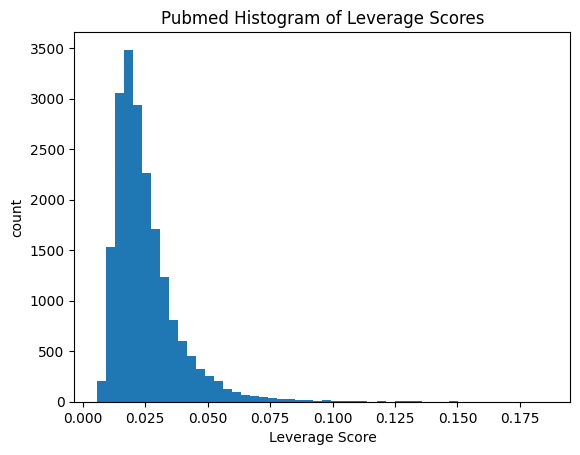

In [14]:
leverage_scores = np.diag(H)
plt.hist(leverage_scores, bins=50)
plt.xlabel('Leverage Score')
plt.ylabel('count')
plt.title(f'{dataset_name} Histogram of Leverage Scores')
plt.savefig(f'img/{dataset_name}_hist_leverage_scores.png')

In [8]:
def biggest_Laplacian_eigen(edge_index, k=5):
    A = np.zeros((NUM_NODES, NUM_NODES))
    for i, j in edge_index.T:
        A[i, j] = A[j, i] = 1
    D = np.diag(np.sum(A, axis=1))
    L = D - A
    eigvals, eigvecs = eigsh(L, k=k, which='LM')
    return eigvals[::-1], eigvecs[:, ::-1]

def biggest_Laplacian_eigenvalues(edge_index, k=5):
    return biggest_Laplacian_eigen(edge_index, k)[0]

def biggest_Laplacian_eigenvectors(edge_index, k=5):
    return biggest_Laplacian_eigen(edge_index, k)[1]

def exclude_idx_edge_index(edge_index, idx):
    return edge_index[:, ~np.isin(edge_index[0], idx) & ~np.isin(edge_index[1], idx)]

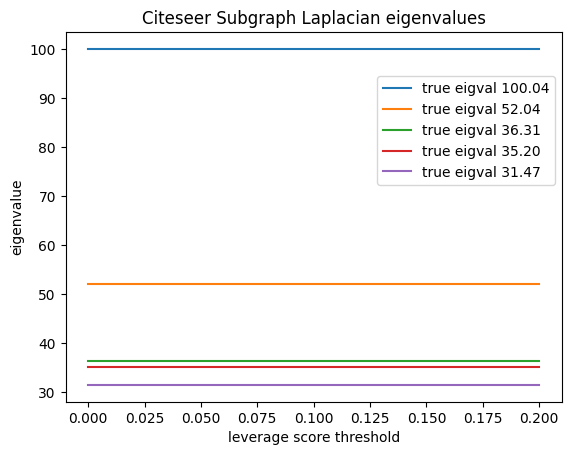

In [9]:
threshold_ls = np.linspace(0, 0.2, 10)
threshold_eigvals = [biggest_Laplacian_eigenvalues(exclude_idx_edge_index(data.edge_index.numpy(), np.where(leverage_scores < t)[0])) for t in threshold_ls]
threshold_eigvals = np.array(threshold_eigvals).transpose()
true_eigvals = biggest_Laplacian_eigenvalues(data.edge_index.numpy())
for t, eigs in enumerate(threshold_eigvals):
    plt.plot(threshold_ls, eigs, label=f'true eigval {true_eigvals[t]:.2f}')
    plt.xlabel('leverage score threshold')
    plt.ylabel('eigenvalue')
    plt.title(f'{dataset_name} Subgraph Laplacian eigenvalues')
    plt.legend(loc='upper right',bbox_to_anchor=(1, 0.9))
    plt.savefig(f'img/{dataset_name}_eigenvalues.png', dpi=300)

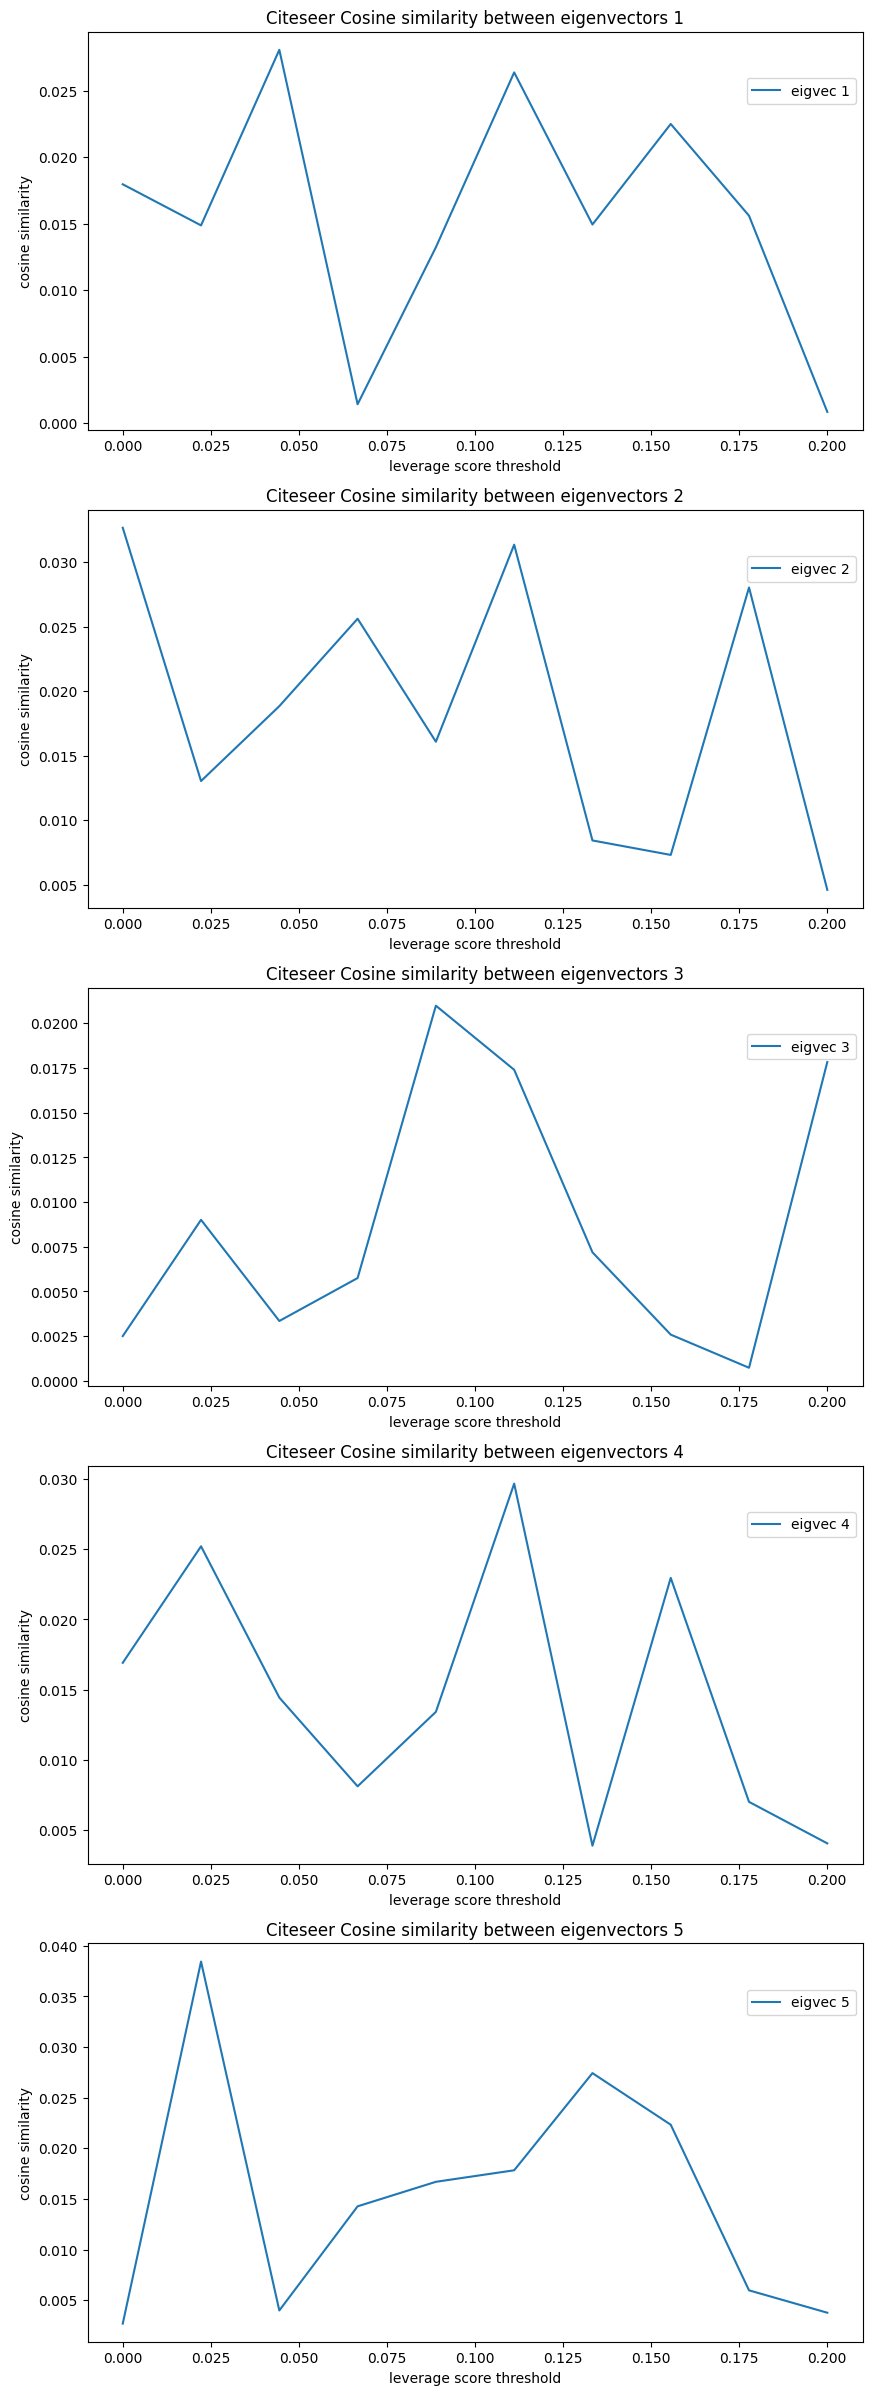

In [10]:
# compare cos between eigenvectors
threshold_eigvecs = [biggest_Laplacian_eigenvectors(exclude_idx_edge_index(data.edge_index.numpy(), np.where(leverage_scores > t)[0])) for t in threshold_ls]
true_eigvecs = biggest_Laplacian_eigenvectors(data.edge_index.numpy())
cos = np.zeros((len(threshold_ls), 5))
for i, eigs in enumerate(threshold_eigvecs):
    for j in range(5):
        cos[i, j] = np.abs(eigs[:, j] @ true_eigvecs[:, j]) / (np.linalg.norm(eigs[:, j]) * np.linalg.norm(true_eigvecs[:, j]))
plt.figure(figsize=(10, 30))
for j in range(5):
    plt.subplot(5, 1, j+1)
    plt.plot(threshold_ls, cos[:, j], label=f'eigvec {j+1}')
    plt.xlabel('leverage score threshold')
    plt.ylabel('cosine similarity')
    plt.title(f'{dataset_name} Cosine similarity between eigenvectors {j+1}')
    plt.legend(loc='upper right',bbox_to_anchor=(1, 0.9))
plt.savefig(f'img/{dataset_name}_cosine_similarity.png', dpi=300)

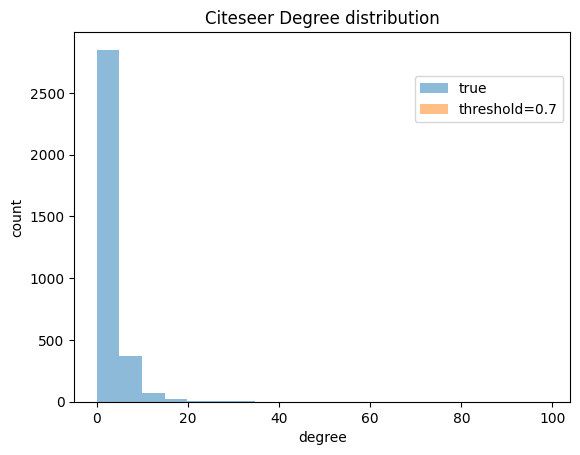

In [11]:
# compare the distribution of degrees
leverage_threshold = 0.7
excluded_idx = np.where(leverage_scores > leverage_threshold)[0]
excluded_edge_idx = exclude_idx_edge_index(data.edge_index.numpy(), excluded_idx)
true_adj = np.zeros((NUM_NODES, NUM_NODES))
for i, j in data.edge_index.numpy().T:
    true_adj[i, j] = true_adj[j, i] = 1
true_degrees = np.sum(true_adj, axis=1)
sampled_adj = np.zeros((NUM_NODES, NUM_NODES))
for i, j in excluded_edge_idx.T:
    sampled_adj[i, j] = sampled_adj[j, i] = 1
sampled_degrees = np.sum(sampled_adj, axis=1)[~np.isin(np.arange(NUM_NODES), excluded_idx)]
plt.hist(true_degrees, bins=20, alpha=0.5, label='true')
plt.hist(sampled_degrees, bins=20, alpha=0.5, label=f'threshold={leverage_threshold}')
plt.xlabel('degree')
plt.ylabel('count')
plt.title(f'{dataset_name} Degree distribution')
plt.legend(loc='upper right',bbox_to_anchor=(1, 0.9))
plt.savefig(f'img/{dataset_name}_degree_distribution.png', dpi=300)